In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monthly-sunspots/monthly-sunspots.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [3]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    df['Month'] = pd.to_datetime(df['Month'])
    df = df.set_index("Month")
    
    # resample the time to 2 Months
    df = df["Sunspots"].resample("2M").mean().fillna(method="ffill").to_frame()
    
    # create df[p2.l1] that will be the shift of p2
    df["Sunspots.L1"] = df["Sunspots"].shift(1)     #.dropna(inplace=True)
    df.dropna(inplace=True)
    
    
    return df

In [4]:
df = wrangle("/kaggle/input/monthly-sunspots/monthly-sunspots.csv")
df.head()

,Sunspots,Sunspots.L1
Month,,
1749-03-31,66.30,58.00
1749-05-31,70.35,66.30
1749-07-31,89.15,70.35
1749-09-30,71.10,89.15
1749-11-30,117.05,71.10


In [5]:
df.isnull().sum()

Sunspots       0
Sunspots.L1    0
dtype: int64

<AxesSubplot:>

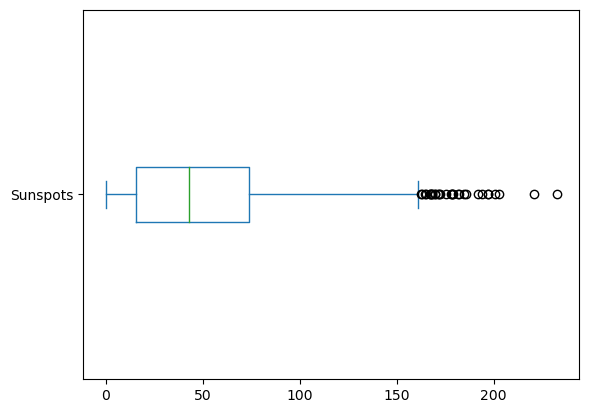

In [6]:
df["Sunspots"].plot(kind="box", vert = False)

In [7]:
df.shape

(1410, 2)

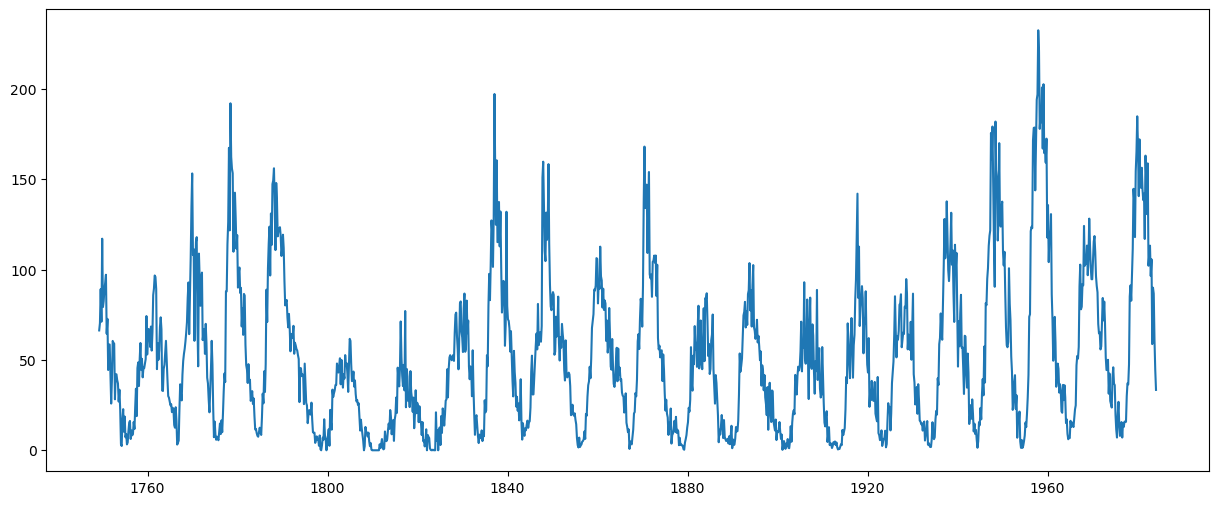

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df["Sunspots"])

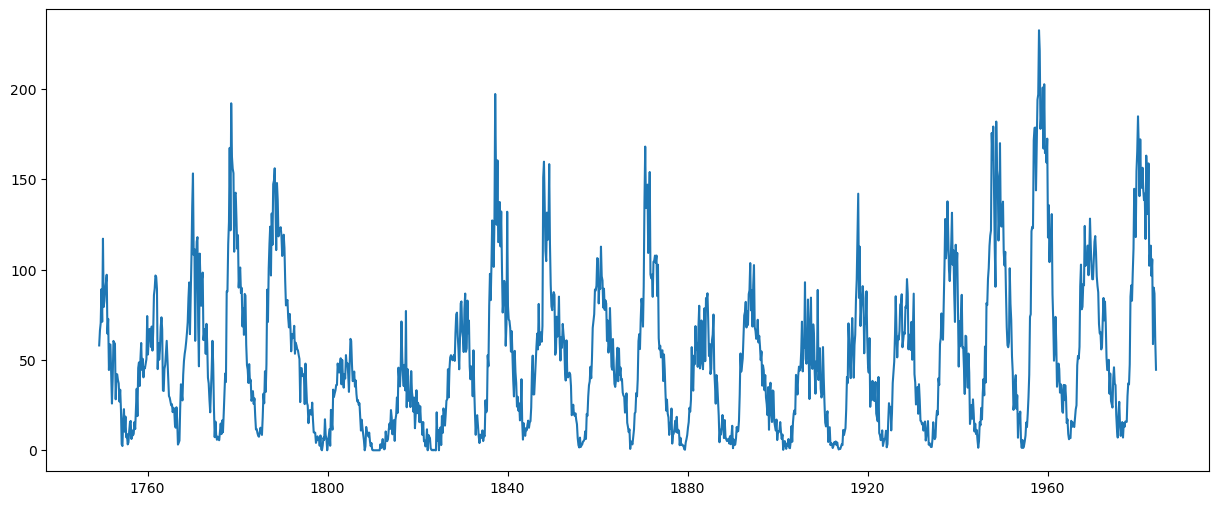

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(df["Sunspots.L1"])

In [10]:
df_dummy = df["Sunspots"].resample("5M").mean()
df_dummy.head()

Month
1749-03-31    66.300000
1749-08-31    79.750000
1750-01-31    89.133333
1750-06-30    85.850000
1750-11-30    84.766667
Freq: 5M, Name: Sunspots, dtype: float64

In [11]:
df_dummy.shape

(565,)

> Here the question arises that, since the data is already in Months,means a single observation is an observation of whole month, so whether we should resample it or not

<AxesSubplot:xlabel='Month'>

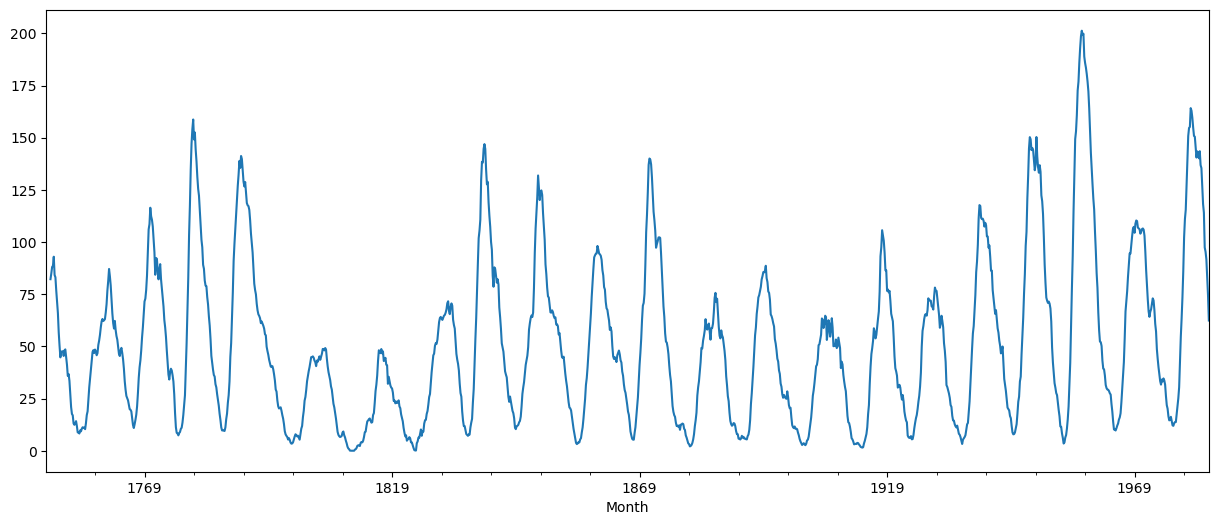

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Sunspots"].rolling(6).mean().plot(ax=ax)

<AxesSubplot:xlabel='Month'>

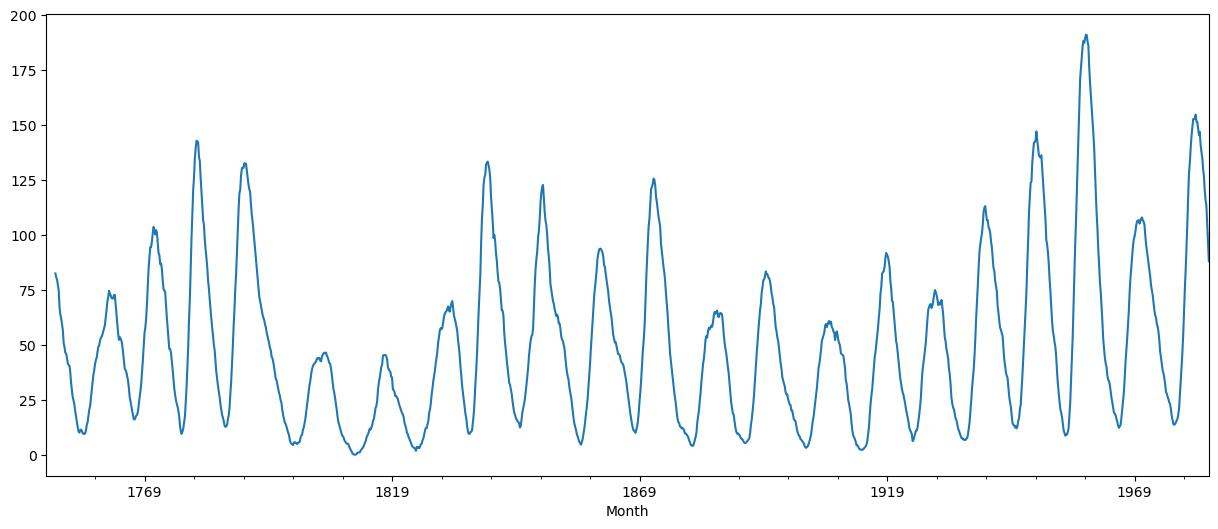

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
df["Sunspots"].rolling(12).mean().plot(ax=ax)

In [14]:
df.corr()

,Sunspots,Sunspots.L1
Sunspots,1.000000,0.931787
Sunspots.L1,0.931787,1.000000


In [15]:
#df.corr(df["Sunspots.L1"].shift(1))

In [16]:
df_dummy = pd.read_csv("/kaggle/input/monthly-sunspots/monthly-sunspots.csv")
df_dummy["Sunspots.L2"] = df_dummy["Sunspots"].shift(2)
df_dummy["Sunspots.L1"] = df_dummy["Sunspots"].shift(1)
df_dummy.corr()

,Sunspots,Sunspots.L2,Sunspots.L1
Sunspots,1.000000,0.890541,0.921718
Sunspots.L2,0.890541,1.000000,0.921713
Sunspots.L1,0.921718,0.921713,1.000000


In [17]:
df.head()

,Sunspots,Sunspots.L1
Month,,
1749-03-31,66.30,58.00
1749-05-31,70.35,66.30
1749-07-31,89.15,70.35
1749-09-30,71.10,89.15
1749-11-30,117.05,71.10


In [18]:
df["Sunspots.L1"].shape

(1410,)

In [19]:
df["Sunspots"].shape

(1410,)

# **Split**

In [20]:
target = "Sunspots"
y = df[target]
X = df.drop(columns=target)

In [21]:
cutoff = int(len(X) * 0.8)

X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

In [22]:
X_train.head()

,Sunspots.L1
Month,
1749-03-31,58.00
1749-05-31,66.30
1749-07-31,70.35
1749-09-30,89.15
1749-11-30,71.10


In [23]:
y_train.head()

Month
1749-03-31     66.30
1749-05-31     70.35
1749-07-31     89.15
1749-09-30     71.10
1749-11-30    117.05
Freq: 2M, Name: Sunspots, dtype: float64

In [24]:
X_train.shape

(1128, 1)

In [25]:
y_train.shape

(1128,)

# **Build Model**

In [26]:
y_pred_baseline = [(y_train.mean())] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 44.7
Baseline MAE: 29.11


In [27]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [28]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 10.35
Test MAE: 13.91


> We are getting mae less that that of baseline, so for now we are good to go